In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import ciu

iris=datasets.load_iris()

df = pd.DataFrame(data = np.c_[iris['data'], iris['target']],
              columns = iris['feature_names'] + ['target'])
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
df.columns = ['s_length', 's_width', 'p_length', 'p_width', 'target', 'species']
iris_outnames = df['species'].cat.categories.tolist()
iris_df = df.apply(pd.to_numeric, errors='ignore')
iris_input_names = df.columns[range(4)]
X = df[iris_input_names]
y = df['species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

print (iris['feature_names'])
df = pd.DataFrame({'mins': iris_df[iris_input_names].min(), 'maxs': iris_df[iris_input_names].max()})
print(df)
print(df.index)
print(df.columns)
print(df.loc['s_width'][['mins']])
print(df[['mins']])

In [2]:
iris_model = LinearDiscriminantAnalysis()
iris_model.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [3]:
inst_ind = 42
instance = X_test.iloc[[inst_ind]]
inst_class = y_test.iloc[inst_ind]
pred = iris_model.predict(instance)[0]
print(f"Instance {inst_ind} in the test set is a {inst_class} and it is predicted to be a {pred}")
print(f"The instance values are:\n{instance}")
iris_model.predict_proba(instance).shape[1]

Instance 42 in the test set is a virginica and it is predicted to be a virginica
The instance values are:
     s_length  s_width  p_length  p_width
143       6.8      3.2       5.9      2.3


3

In [4]:
ciu_obj = ciu.CIU(iris_model.predict_proba, iris_outnames, data=X)

In [5]:
print(type(ciu_obj.in_minmaxs))
print(ciu_obj.in_minmaxs)
row_by_position = ciu_obj.in_minmaxs.loc['s_width']  # Gets the second row (index 1)

print("Row by Position:")
print(row_by_position.iloc[0])
print(ciu_obj.in_minmaxs.shape[0])

<class 'pandas.core.frame.DataFrame'>
          mins  maxs
s_length   4.3   7.9
s_width    2.0   4.4
p_length   1.0   6.9
p_width    0.1   2.5
Row by Position:
2.0
4


In [6]:
print(ciu_obj.in_minmaxs)
mins = np.array(ciu_obj.in_minmaxs.iloc[0:4,0])
maxs = np.array(ciu_obj.in_minmaxs.iloc[0:4,1])
print(mins)
print(maxs)

          mins  maxs
s_length   4.3   7.9
s_width    2.0   4.4
p_length   1.0   6.9
p_width    0.1   2.5
[4.3 2.  1.  0.1]
[7.9 4.4 6.9 2.5]


In [7]:
from itertools import product
minmaxgrid = pd.DataFrame(list(product(*ciu_obj.in_minmaxs.values[[0,2],:])))
#minmaxgrid.values.reshape(8,4)
print(minmaxgrid)

     0    1
0  4.3  1.0
1  4.3  6.9
2  7.9  1.0
3  7.9  6.9


In [8]:
estimator = ciu.PerturbationMinMaxEstimator.PerturbationMinMaxEstimator(iris_model.predict_proba, ciu_obj.in_minmaxs, 150)
mins, maxs = estimator.get_minmax_outvals(instance, [1])
print(mins)
print(maxs)

[1.75974558e-52 4.97705992e-08 9.99762639e-01]
[4.11531032e-33 2.37361325e-04 9.99999950e-01]


In [9]:
print(iris_model.predict(instance))
res = ciu_obj.explain_core([2,3], instance, nsamples=1000)
petal_ciu=pd.concat(res)
display(petal_ciu)

['virginica']


,CI,CU,Cinfl,outname,outval,feature,ymin,ymax,inputs,invals,neutralCU,target_concept,target_inputs
Coalition of 2 inputs,1.0,8.510916e-43,-0.5,setosa,8.510916e-43,Coalition of 2 inputs,3.632469e-58,1.0,"[2, 3]","[5.9, 2.3]",0.5,None,None


A "target coalition" can be indicated with the `target_inputs` parameter. Here `[2,3]` signifies the two petal features.

In [10]:
res_ic = ciu_obj.explain_core([2], instance, nsamples=1000, target_inputs=[2,3])
display(pd.concat(res_ic))

,CI,CU,Cinfl,outname,outval,feature,ymin,ymax,inputs,invals,neutralCU,target_concept,target_inputs
p_length,1.0,8.510917e-43,-0.5,setosa,8.510916e-43,p_length,4.286756e-55,1.0,[2],[5.9],0.5,None,"[2, 3]"


However, if CIU has already been calculated for the target coalition (i.e., intermediate concept), then it is better to use that result directly and pass the `ymin` and `ymax` values dorectly to the parameter `out_minmaxs`. That guarantees consistent CIU values between calculations and also avoid re-doing the CIU calculation for the target intermediate concept. 

In [11]:
res_ic = ciu_obj.explain_core([2], instance, nsamples=1000, out_minmaxs=petal_ciu.loc[:,['ymin','ymax']])
display(pd.concat(res_ic))

,CI,CU,Cinfl,outname,outval,feature,ymin,ymax,inputs,invals,neutralCU,target_concept,target_inputs
p_length,1.0,8.510917e-43,-0.5,setosa,8.510916e-43,p_length,4.286756e-55,1.0,[2],[5.9],0.5,None,None


In [12]:
print(ciu_obj.in_minmaxs)
print(ciu_obj.in_minmaxs.loc['s_length'].iloc[0])

          mins  maxs
s_length   4.3   7.9
s_width    2.0   4.4
p_length   1.0   6.9
p_width    0.1   2.5
4.3


It is possible to get CIU results for all outputs in one go into the same DataFrame (even though that's not usually what you want but can be more efficient and stable):

In [13]:
CIUres = ciu_obj.explain(instance, output_inds=[1,2])
display(CIUres)

,CI,CU,Cinfl,outname,outval,feature,ymin,ymax,inputs,invals,neutralCU,target_concept,target_inputs
s_length,0.000147,0.023350,-0.000070,versicolor,0.000003,s_length,6.727409e-10,0.000147,[0],[6.8],0.5,None,None
s_length,0.000147,0.976650,0.000070,virginica,0.999997,s_length,9.998528e-01,1.000000,[0],[6.8],0.5,None,None
s_width,0.000237,0.014275,-0.000115,versicolor,0.000003,s_width,4.977060e-08,0.000237,[1],[3.2],0.5,None,None
s_width,0.000237,0.985725,0.000115,virginica,0.999997,s_width,9.997626e-01,1.000000,[1],[3.2],0.5,None,None
p_length,0.999998,0.000003,-0.499996,versicolor,0.000003,p_length,1.468630e-09,0.999998,[2],[5.9],0.5,None,None
p_length,1.000000,0.999997,0.499997,virginica,0.999997,p_length,6.464905e-19,1.000000,[2],[5.9],0.5,None,None
p_width,1.000000,0.000003,-0.499997,versicolor,0.000003,p_width,2.347277e-07,1.000000,[3],[2.3],0.5,None,None
p_width,1.000000,0.999997,0.499997,virginica,0.999997,p_width,4.378181e-08,1.000000,[3],[2.3],0.5,None,None


p_length


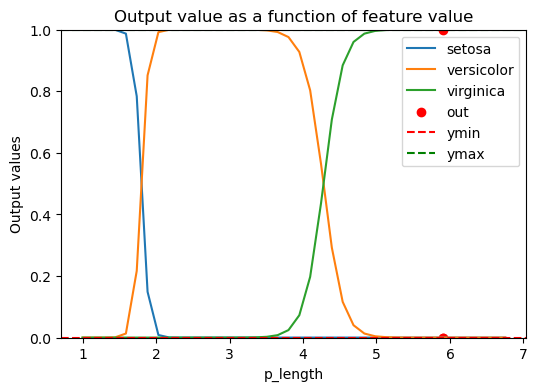

In [14]:
print(ciu_obj.input_names[2])
ciu_obj.plot_input_output(ind_input=2, output_inds=[0,1,2], illustrate_CIU=True)


It is usually smarter to call `explain()` with only one `output_inds` value and then pass the result directly to the plotting methods. However, it can be more efficient (and stable) to get CIU values for all outputs with one single call. In that case, one can extract the values for a specific output like this:

,CI,CU,Cinfl,outname,outval,feature,ymin,ymax,inputs,invals,neutralCU,target_concept,target_inputs
s_length,1.263354e-37,6.736764e-06,-6.316684e-38,setosa,8.510916e-43,s_length,1.500777e-54,1.263354e-37,[0],[6.8],0.5,None,None
s_length,1.471875e-04,2.334993e-02,-7.015693e-05,versicolor,3.437490e-06,s_length,6.727409e-10,1.471882e-04,[0],[6.8],0.5,None,None
s_length,1.471875e-04,9.766501e-01,7.015693e-05,virginica,9.999966e-01,s_length,9.998528e-01,1.000000e+00,[0],[6.8],0.5,None,None
s_width,4.115310e-33,2.068110e-10,-2.057655e-33,setosa,8.510916e-43,s_width,1.759746e-52,4.115310e-33,[1],[3.2],0.5,None,None
s_width,2.373116e-04,1.427541e-02,-1.152681e-04,versicolor,3.437490e-06,s_width,4.977060e-08,2.373613e-04,[1],[3.2],0.5,None,None
s_width,2.373116e-04,9.857246e-01,1.152681e-04,virginica,9.999966e-01,s_width,9.997626e-01,1.000000e+00,[1],[3.2],0.5,None,None
p_length,9.999999e-01,8.510917e-43,-5.000000e-01,setosa,8.510916e-43,p_length,4.286756e-55,9.999999e-01,[2],[5.9],0.5,None,None
p_length,9.999906e-01,3.436054e-06,-4.999919e-01,versicolor,3.437490e-06,p_length,1.468630e-09,9.999906e-01,[2],[5.9],0.5,None,None
p_length,1.000000e+00,9.999966e-01,4.999966e-01,virginica,9.999966e-01,p_length,6.464905e-19,1.000000e+00,[2],[5.9],0.5,None,None
p_width,2.303921e-16,3.690970e-27,-1.151960e-16,setosa,8.510916e-43,p_width,7.211918e-46,2.303921e-16,[3],[2.3],0.5,None,None


,CI,CU,Cinfl,outname,outval,feature,ymin,ymax,inputs,invals,neutralCU,target_concept,target_inputs
s_length,0.000147,0.976650,0.000070,virginica,0.999997,s_length,9.998528e-01,1.0,[0],[6.8],0.5,None,None
s_width,0.000237,0.985725,0.000115,virginica,0.999997,s_width,9.997626e-01,1.0,[1],[3.2],0.5,None,None
p_length,1.000000,0.999997,0.499997,virginica,0.999997,p_length,6.464905e-19,1.0,[2],[5.9],0.5,None,None
p_width,1.000000,0.999997,0.499997,virginica,0.999997,p_width,4.378181e-08,1.0,[3],[2.3],0.5,None,None


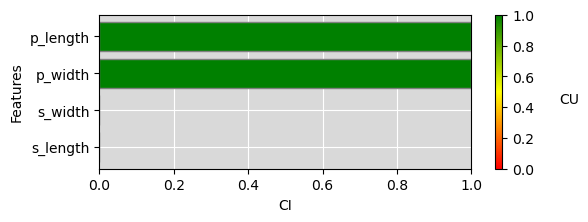

In [15]:
CIUres = ciu_obj.explain(instance, output_inds=[0,1,2])
display(CIUres)
CIUres = CIUres[CIUres['outname'] == 'virginica']
display(CIUres)
ciu_obj.plot_ciu(CIUres, figsize=(6,2))

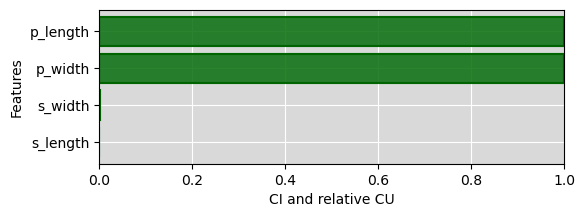

In [16]:
ciu_obj.plot_ciu(CIUres, plot_mode='overlap', figsize=(6,2))

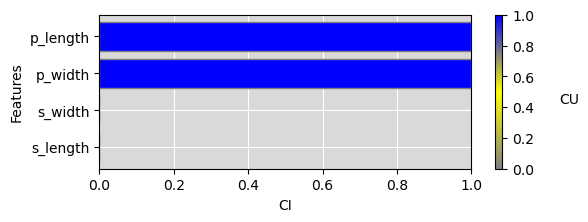

In [17]:
ciu_obj.plot_ciu(CIUres, color_blind='protanopia', figsize=(6,2))

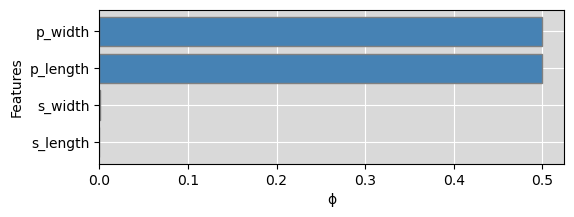

In [18]:
ciu_obj.plot_influence(CIUres, figsize=(6,2))

In [19]:
text_ciu = ciu_obj.textual_explanation(CIUres)
print(text_ciu)


The explained value is virginica with the value 1.00 (CU=1.00), which is high utility.
Feature s_length has very low importance (CI=0.00) and has value(s) 6.8, which is high utility (CU=0.98)
Feature s_width has very low importance (CI=0.00) and has value(s) 3.2, which is high utility (CU=0.99)
Feature p_length has very high importance (CI=1.00) and has value(s) 5.9, which is high utility (CU=1.00)
Feature p_width has very high importance (CI=1.00) and has value(s) 2.3, which is high utility (CU=1.00)



In [20]:
from IPython.display import Markdown
markdown_text = ciu_obj.textual_explanation(CIUres, use_markdown_effects=True)
Markdown(markdown_text)

The explained value is ***virginica*** with the value 1.00 (CU=1.00), which is **high utility**.<br>Feature *s_length* has **very low importance (CI=0.00)** and has value(s) 6.8, which is **high utility (CU=0.98)**<br>Feature *s_width* has **very low importance (CI=0.00)** and has value(s) 3.2, which is **high utility (CU=0.99)**<br>Feature *p_length* has **very high importance (CI=1.00)** and has value(s) 5.9, which is **high utility (CU=1.00)**<br>Feature *p_width* has **very high importance (CI=1.00)** and has value(s) 2.3, which is **high utility (CU=1.00)**<br>